# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

In [1]:
!pip uninstall -y torch
!pip install torch==2.6.0


Found existing installation: torch 2.6.0
Uninstalling torch-2.6.0:
  Successfully uninstalled torch-2.6.0
Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for torch==2.6.0 from https://files.pythonhosted.org/packages/78/a9/97cbbc97002fff0de394a2da2cdfa859481fdca36996d7bd845d50aa9d8d/torch-2.6.0-cp311-cp311-manylinux1_x86_64.whl.metadata
  Using cached torch-2.6.0-cp311-cp311-manylinux1_x86_64.whl.metadata (28 kB)
Using cached torch-2.6.0-cp311-cp311-manylinux1_x86_64.whl (766.7 MB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
!pip uninstall -y torchvision
!pip install torchvision

import torchvision
print(torchvision.__version__)


Found existing installation: torchvision 0.21.0
Uninstalling torchvision-0.21.0:
  Successfully uninstalled torchvision-0.21.0
Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/be/a2/b0cedf0a411f1a5d75cfc0b87cde56dd1ddc1878be46a42c905cd8580220/torchvision-0.21.0-cp311-cp311-manylinux1_x86_64.whl.metadata
  Using cached torchvision-0.21.0-cp311-cp311-manylinux1_x86_64.whl.metadata (6.1 kB)
Using cached torchvision-0.21.0-cp311-cp311-manylinux1_x86_64.whl (7.2 MB)

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
0.21.0+cu124


In [3]:
# TODO: Make all necessary imports.

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import json


In [4]:
!pip show torch

import torch
print(torch.__version__)
print(torch.cuda.is_available()) 

Name: torch
Version: 2.6.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /home/student/.local/lib/python3.11/site-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-cusparselt-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvtx-cu12, sympy, triton, typing-extensions
Required-by: torchvision
2.6.0+cu124
False


/home/student/.local/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 34: CUDA driver is a stub library (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [ ]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import logging
import tensorflow as tf
import tensorflow_datasets as tfds

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.ERROR)

try:
    dataset, dataset_info = tfds.load("oxford_flowers102", with_info=True, as_supervised=True)
    print("Dataset loaded successfully.")

    # splitting the dataset
    train_dataset = dataset['train']
    valid_dataset = dataset['validation']
    test_dataset = dataset['test']
    print("Dataset split into train, validation, and test sets.")

    # preprocessing function
    def preprocess(image, label):
        image = tf.image.resize(image, (224, 224))  # Resize to 224x224
        image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
        return image, label

    # Apply preprocessing and batching
    train_dataset = train_dataset.map(preprocess).shuffle(1000).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
    valid_dataset = valid_dataset.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

    print("Dataset preprocessed and batched successfully.")

    # testing one batch
    for img, lbl in train_dataset.take(1):
        print("One Batch Shape:", img.shape)
        break

except Exception as e:
    print("Error occurred:", str(e))

2025-03-06 15:00:32.616310: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-06 15:00:32.616400: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-06 15:00:32.616463: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|          | 0/1 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|          | 0/2 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|          | 0/3 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|          | 0/3 [00:01<?, ? url/s]
Dl Size...: 0 MiB [00:01, ? MiB/s]

Dl Completed...:  33%|███▎      | 1/3 [00:01<00:03,  1.51s/ url]
Dl Size...: 0 MiB [00:01, ? MiB/s]

Dl Size...:   0%|          | 0/328 [00:01<?, ? MiB/s]

Dl Size...:   0%|          | 0/328 [00:01<?, ? MiB/s]

Dl Size...:   0%|          | 0/328 [00:01<?, ? MiB/s]

Extraction completed...: 0 file [00:01, ? file/s]
Dl Size...:   0%|          | 1/328 [00:02<11:43,  2.15s/ MiB]

Dl Size...:   1%|          | 2/328 [00:02<11:41,  2.15s/ MiB]

Dl Size...:   1%|          | 3/328 [00:02<11:39,  2.15s/ MiB]

Dl Size...:   1%|          | 4/328 [00:02<11:37

Dl Size...:  16%|█▋        | 54/328 [00:05<00:21, 12.87 MiB/s]

Dl Size...:  17%|█▋        | 55/328 [00:05<00:21, 12.87 MiB/s]

Dl Size...:  17%|█▋        | 56/328 [00:05<00:21, 12.87 MiB/s]

Dl Size...:  17%|█▋        | 57/328 [00:05<00:21, 12.87 MiB/s]

Dl Size...:  18%|█▊        | 58/328 [00:05<00:20, 12.87 MiB/s]

Dl Size...:  18%|█▊        | 59/328 [00:05<00:20, 12.87 MiB/s]

Dl Size...:  18%|█▊        | 60/328 [00:05<00:20, 12.87 MiB/s]

Dl Size...:  19%|█▊        | 61/328 [00:05<00:20, 12.87 MiB/s]

Dl Size...:  19%|█▉        | 62/328 [00:05<00:20, 12.87 MiB/s]

Dl Size...:  19%|█▉        | 63/328 [00:05<00:20, 12.87 MiB/s]

Dl Size...:  20%|█▉        | 64/328 [00:05<00:20, 12.87 MiB/s]

Dl Size...:  20%|█▉        | 65/328 [00:06<00:20, 12.87 MiB/s]

Dl Size...:  20%|██        | 66/328 [00:06<00:20, 12.87 MiB/s]

Dl Size...:  20%|██        | 67/328 [00:06<00:20, 12.87 MiB/s]

Dl Size...:  21%|██        | 68/328 [00:06<00:20, 12.87 MiB/s]

Dl Size...:  21%|██        | 69/328 [00:

Dl Size...:  35%|███▍      | 114/328 [00:08<00:12, 17.20 MiB/s]

Dl Size...:  35%|███▌      | 115/328 [00:08<00:12, 17.20 MiB/s]

Dl Size...:  35%|███▌      | 116/328 [00:08<00:12, 17.20 MiB/s]

Dl Size...:  36%|███▌      | 117/328 [00:08<00:12, 17.20 MiB/s]

Dl Size...:  36%|███▌      | 118/328 [00:08<00:12, 17.20 MiB/s]

Dl Size...:  36%|███▋      | 119/328 [00:08<00:12, 17.20 MiB/s]

Dl Size...:  37%|███▋      | 120/328 [00:08<00:12, 17.20 MiB/s]

Dl Size...:  37%|███▋      | 121/328 [00:08<00:12, 17.20 MiB/s]

Dl Size...:  37%|███▋      | 122/328 [00:08<00:11, 17.20 MiB/s]

Dl Size...:  38%|███▊      | 123/328 [00:09<00:11, 17.20 MiB/s]

Dl Size...:  38%|███▊      | 124/328 [00:09<00:11, 17.20 MiB/s]

Dl Size...:  38%|███▊      | 125/328 [00:09<00:11, 17.20 MiB/s]

Dl Size...:  38%|███▊      | 126/328 [00:09<00:11, 17.20 MiB/s]

Dl Size...:  39%|███▊      | 127/328 [00:09<00:11, 17.20 MiB/s]

Dl Size...:  39%|███▉      | 128/328 [00:09<00:11, 17.20 MiB/s]

Dl Size...:  39%|███▉    

Dl Size...:  53%|█████▎    | 174/328 [00:11<00:08, 18.54 MiB/s]

Dl Size...:  53%|█████▎    | 175/328 [00:11<00:08, 18.54 MiB/s]

Dl Size...:  54%|█████▎    | 176/328 [00:11<00:08, 18.54 MiB/s]

Dl Size...:  54%|█████▍    | 177/328 [00:11<00:08, 18.54 MiB/s]

Dl Size...:  54%|█████▍    | 178/328 [00:11<00:08, 18.54 MiB/s]

Dl Size...:  55%|█████▍    | 179/328 [00:11<00:08, 18.54 MiB/s]

Dl Size...:  55%|█████▍    | 180/328 [00:12<00:07, 18.54 MiB/s]

Dl Size...:  55%|█████▌    | 181/328 [00:12<00:07, 18.54 MiB/s]

Dl Size...:  55%|█████▌    | 182/328 [00:12<00:07, 18.54 MiB/s]

Dl Size...:  56%|█████▌    | 183/328 [00:12<00:07, 18.54 MiB/s]

Dl Size...:  56%|█████▌    | 184/328 [00:12<00:07, 18.54 MiB/s]

Dl Size...:  56%|█████▋    | 185/328 [00:12<00:07, 18.54 MiB/s]

Dl Size...:  57%|█████▋    | 186/328 [00:12<00:07, 18.54 MiB/s]

Dl Size...:  57%|█████▋    | 187/328 [00:12<00:07, 18.54 MiB/s]

Dl Size...:  57%|█████▋    | 188/328 [00:12<00:07, 18.54 MiB/s]

Dl Size...:  58%|█████▊  

Dl Size...:  71%|███████▏  | 234/328 [00:14<00:04, 19.03 MiB/s]

Dl Size...:  72%|███████▏  | 235/328 [00:14<00:04, 19.03 MiB/s]

Dl Size...:  72%|███████▏  | 236/328 [00:14<00:04, 19.03 MiB/s]

Dl Size...:  72%|███████▏  | 237/328 [00:14<00:04, 19.03 MiB/s]

Dl Size...:  73%|███████▎  | 238/328 [00:14<00:04, 19.03 MiB/s]

Dl Size...:  73%|███████▎  | 239/328 [00:15<00:04, 19.03 MiB/s]

Dl Size...:  73%|███████▎  | 240/328 [00:15<00:04, 19.03 MiB/s]

Dl Size...:  73%|███████▎  | 241/328 [00:15<00:04, 19.03 MiB/s]

Dl Size...:  74%|███████▍  | 242/328 [00:15<00:04, 19.03 MiB/s]

Dl Size...:  74%|███████▍  | 243/328 [00:15<00:04, 19.03 MiB/s]

Dl Size...:  74%|███████▍  | 244/328 [00:15<00:04, 19.03 MiB/s]

Dl Size...:  75%|███████▍  | 245/328 [00:15<00:04, 19.03 MiB/s]

Dl Size...:  75%|███████▌  | 246/328 [00:15<00:04, 19.03 MiB/s]

Dl Size...:  75%|███████▌  | 247/328 [00:15<00:04, 19.03 MiB/s]

Dl Size...:  76%|███████▌  | 248/328 [00:15<00:04, 19.03 MiB/s]

Dl Size...:  76%|███████▌

Dl Size...:  90%|████████▉ | 294/328 [00:17<00:01, 19.76 MiB/s]

Dl Size...:  90%|████████▉ | 295/328 [00:17<00:01, 19.76 MiB/s]

Dl Size...:  90%|█████████ | 296/328 [00:17<00:01, 19.76 MiB/s]

Dl Size...:  91%|█████████ | 297/328 [00:17<00:01, 19.76 MiB/s]

Dl Size...:  91%|█████████ | 298/328 [00:17<00:01, 19.76 MiB/s]

Dl Size...:  91%|█████████ | 299/328 [00:18<00:01, 19.76 MiB/s]

Dl Size...:  91%|█████████▏| 300/328 [00:18<00:01, 19.76 MiB/s]

Dl Size...:  92%|█████████▏| 301/328 [00:18<00:01, 19.76 MiB/s]

Dl Size...:  92%|█████████▏| 302/328 [00:18<00:01, 19.76 MiB/s]

Dl Size...:  92%|█████████▏| 303/328 [00:18<00:01, 19.76 MiB/s]

Dl Size...:  93%|█████████▎| 304/328 [00:18<00:01, 19.76 MiB/s]

Dl Size...:  93%|█████████▎| 305/328 [00:18<00:01, 19.76 MiB/s]

Dl Size...:  93%|█████████▎| 306/328 [00:18<00:01, 19.76 MiB/s]

Dl Size...:  94%|█████████▎| 307/328 [00:18<00:01, 19.76 MiB/s]

Dl Size...:  94%|█████████▍| 308/328 [00:18<00:01, 19.76 MiB/s]

Dl Size...:  94%|████████

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [00:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:15<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:16<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:25<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:26<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:35<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:36<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:37<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:38<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:39<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:40<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:41<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:42<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Extraction completed...:   0%|          | 0/8189 [01:43<?, ? file/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|███

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:43<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:44<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:45<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:46<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:47<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:48<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:49<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:50<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:51<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:52<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:53<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:54<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:55<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Extraction completed...:  23%|██▎       | 1903/8189 [01:56<01:08, 91.97 file/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size..

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:56<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:57<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Extraction completed...:  27%|██▋       | 2213/8189 [01:58<00:54, 110.53 file/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size.

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:58<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Extraction completed...:  29%|██▉       | 2366/8189 [01:59<00:46, 123.92 file/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size.

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [01:59<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:00<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:01<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:02<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:03<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Extraction completed...: 

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:04<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Extraction completed...:  40%|████      | 3309/8189 [02:05<00:35, 138.74 file/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size.

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:05<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:06<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:07<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Extraction completed...:  46%|████▌     | 3738/8189 [02:08<00:32, 137.20 file/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size.

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:08<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 20.17 MiB/s]

Extraction completed...:  48%|████▊     | 3896/8189 [02:09<00:31, 138.48 file/s]

Dl Size...: 100%|██████████| 328/328 [02:09<00:00, 20.17 MiB/s]

Dl Size.

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Extraction completed...:  49%|████▉     | 4042/8189 [02:10<00:28, 144.11 file/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:10<00:00, 20.17 MiB/s]

Dl Size.

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:11<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:12<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Extraction completed...:  55%|█████▍    | 4469/8189 [02:13<00:26, 139.44 file/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:13<00:00, 20.17 MiB/s]

Dl Size.

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:14<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:17<00:00, 20.17 MiB/s]

Extraction completed...:  62%|██████▏   | 5092/8189 [02:17<00:20, 153.69 file/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 20.17 MiB/s]

Dl Size.

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:18<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:19<00:00, 20.17 MiB/s]

Extraction completed...:  64%|██████▍   | 5269/8189 [02:19<00:19, 153.20 file/s]

Dl Size...: 100%|██████████| 328/328 [02:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:19<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:19<00:00, 20.17 MiB/s]

Dl Size.

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:20<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Extraction completed...:  68%|██████▊   | 5581/8189 [02:21<00:17, 148.73 file/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size.

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:21<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:22<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:23<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:24<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:27<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:28<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:29<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:30<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:31<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Extraction completed...:  92%|█████████▏| 7567/8189 [02:32<00:03, 181.99 file/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size.

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:32<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:33<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|████████

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 20.17 MiB/s]

Extraction completed...:  97%|█████████▋| 7934/8189 [02:34<00:01, 181.61 file/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 20.17 MiB/s]

Dl Size...: 100%|██████████| 328/328 [02:34<00:00, 20.17 MiB/s]

Dl Size.

Dataset oxford_flowers102 downloaded and prepared to /home/student/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
Dataset loaded successfully.
Dataset split into train, validation, and test sets.
Dataset preprocessed and batched successfully.
One Batch Shape: (32, 224, 224, 3)


## Explore the Dataset

In [6]:
# TODO: Get the number of examples in each set from the dataset info.
num_train_examples = dataset_info.splits['train'].num_examples
num_valid_examples = dataset_info.splits['validation'].num_examples
num_test_examples = dataset_info.splits['test'].num_examples

print(f"Number of training examples: {num_train_examples}")
print(f"Number of validation examples: {num_valid_examples}")
print(f"Number of test examples: {num_test_examples}")


# TODO: Get the number of classes in the dataset from the dataset info.
num_classes = dataset_info.features['label'].num_classes
print(f"Number of classes: {num_classes}")

Number of training examples: 1020
Number of validation examples: 1020
Number of test examples: 6149
Number of classes: 102


In [7]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
for i, (image, label) in enumerate(train_dataset.take(3)):
    print(f"Image {i+1} - Shape: {image.shape}, Label: {label.numpy()}")

Image 1 - Shape: (32, 224, 224, 3), Label: [ 18  40  48  21  89  35  51  44  71  65  33  46  72  30  45  75  96  97
  54  83   6  60  29  89   6  56  47  14 101  64 101  28]
Image 2 - Shape: (32, 224, 224, 3), Label: [ 51  67  42  10  62   4  25  69  29  90  40  13  18  73  62  89  27  92
  48  56  53  78  12   4  13  71  43  77  24  14  73 101]
Image 3 - Shape: (32, 224, 224, 3), Label: [84 10 68 90 95 17 16 37 66 78 15 36 53 72 28  9 78 31 87 40 20 23 65 84
 30 85 49 98 75 44 55 63]


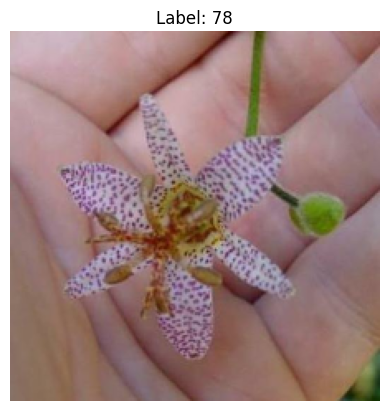

In [8]:
import matplotlib.pyplot as plt

# TODO: Plot 1 image from the training set. Set the title of the plot to the corresponding image label.
for image, label in train_dataset.take(1):
    plt.imshow(image[0].numpy())
    plt.title(f"Label: {label[0].numpy()}")
    plt.axis('off') 
    plt.show()


### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [9]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

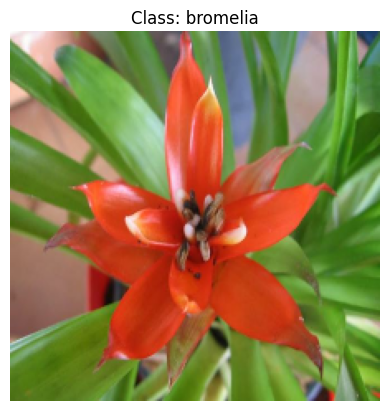

In [10]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 

for image, label in train_dataset.take(1):
    img = image[0].numpy()
    lbl = label[0].numpy()

    # mapping
    class_name = class_names[str(lbl)]

    # Plot the image
    plt.imshow(img)
    plt.title(f"Class: {class_name}")
    plt.axis('off')
    plt.show()



## Create Pipeline

In [ ]:
# def preprocess(image, label):
#     image = tf.image.resize(image, (224, 224))  
#     image = image / 255.0  
#     return image, label

# train_dataset = (
#     train_dataset
#     .map(preprocess)  
#     .shuffle(1000)    
#     .batch(32)        
#     .prefetch(tf.data.experimental.AUTOTUNE)  
# )

# valid_dataset = (
#     valid_dataset
#     .map(preprocess)
#     .batch(32)     
#     .prefetch(tf.data.experimental.AUTOTUNE) 
# )

# test_dataset = (
#     test_dataset
#     .map(preprocess)
#     .batch(32)
#     .prefetch(tf.data.experimental.AUTOTUNE)
# )

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [12]:
# TODO: Build and train your network.

import tensorflow_hub as hub

mobilenet_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(mobilenet_url, input_shape=(224, 224, 3), trainable=False)


In [13]:
import tensorflow as tf

# Build the model
model = tf.keras.Sequential([
    feature_extractor, 
    tf.keras.layers.Dense(1024, activation='relu'), 
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(102, activation='softmax') 
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
#train the model
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=10 
)

print("complete")

Epoch 1/10
32/32 [==============================] - 125s 4s/step - loss: 3.8997 - accuracy: 0.1941 - val_loss: 2.2612 - val_accuracy: 0.5549
Epoch 2/10
32/32 [==============================] - 115s 4s/step - loss: 1.1873 - accuracy: 0.7363 - val_loss: 1.2886 - val_accuracy: 0.6980
Epoch 3/10
32/32 [==============================] - 113s 4s/step - loss: 0.4729 - accuracy: 0.8922 - val_loss: 1.0647 - val_accuracy: 0.7500
Epoch 4/10
32/32 [==============================] - 111s 3s/step - loss: 0.2213 - accuracy: 0.9627 - val_loss: 0.9259 - val_accuracy: 0.7559
Epoch 5/10
32/32 [==============================] - 110s 3s/step - loss: 0.1074 - accuracy: 0.9873 - val_loss: 0.8485 - val_accuracy: 0.7873
Epoch 6/10
32/32 [==============================] - 104s 3s/step - loss: 0.0611 - accuracy: 0.9961 - val_loss: 0.8347 - val_accuracy: 0.7863
Epoch 7/10
32/32 [==============================] - 112s 3s/step - loss: 0.0407 - accuracy: 0.9980 - val_loss: 0.8439 - val_accuracy: 0.7745
Epoch 8/10
32

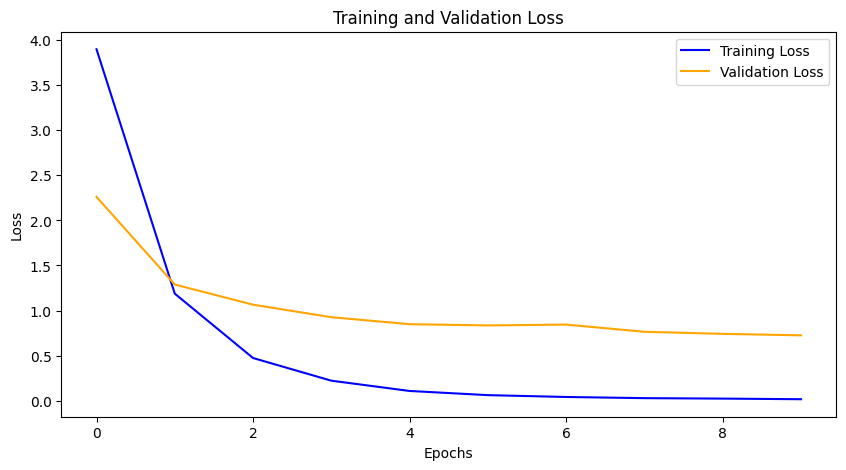

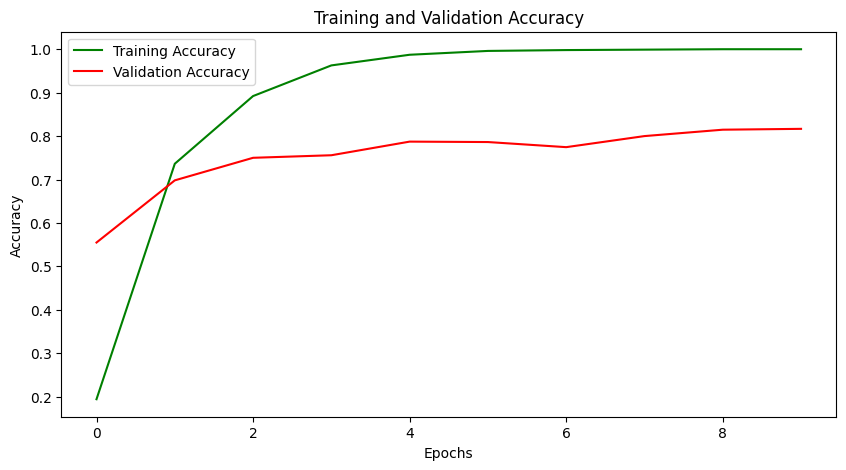

In [15]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [16]:
# TODO: Print the loss and accuracy values achieved on the entire test set.
test_loss, test_accuracy = model.evaluate(test_dataset)

print("\n--- Final Test Results ---")
print(f"Test Loss: {test_loss:.2f}")
print(f"Test Accuracy: {test_accuracy:.2%}")


193/193 [==============================] - 344s 2s/step - loss: 0.8527 - accuracy: 0.7801

--- Final Test Results ---
Test Loss: 0.85
Test Accuracy: 78.01%


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [21]:
# TODO: Save your trained model as a Keras model.

model.save('flower_classifier.h5')

print("Model saved as 'flower_classifier.h5'")



Model saved as 'flower_classifier.h5'


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Load the Keras Model

Load the Keras model you saved above.

In [22]:
# TODO: Load the Keras model

import tensorflow as tf
import tensorflow_hub as hub

loaded_model = tf.keras.models.load_model('flower_classifier.h5', custom_objects={'KerasLayer': hub.KerasLayer})

print("loaded successfully")


loaded successfully


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [24]:
# TODO: Create the process_image function

import numpy as np
from PIL import Image
import tensorflow as tf

def process_image(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))
    image_array = np.asarray(image)
    image_array = image_array / 255.0
    image_array = tf.image.resize(image_array, (224, 224))
    return image_array.numpy()


To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

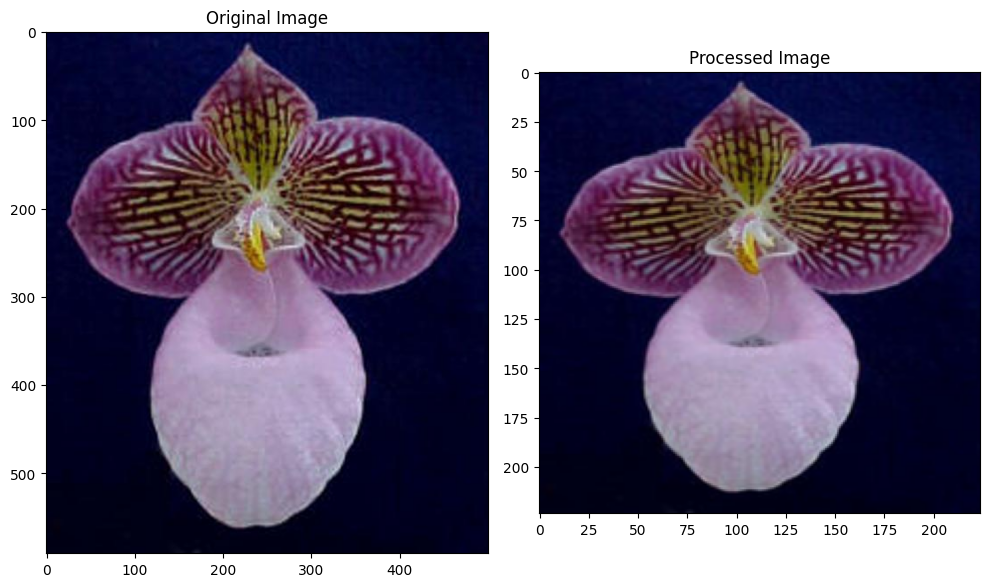

In [25]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

image_path = './test_images/hard-leaved_pocket_orchid.jpg'

# Original Image
im = Image.open(image_path)
test_image = np.asarray(im)

# Processed Image using process_image function
processed_test_image = process_image(image_path)

# Plot Original and Processed Images
fig, (ax1, ax2) = plt.subplots(figsize=(10, 10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()


Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [27]:
# TODO: Create the predict function

import numpy as np

def predict(image_path, model, top_k=5):
    processed_image = process_image(image_path)
    processed_image = np.expand_dims(processed_image, axis=0)
    predictions = model.predict(processed_image)
    top_k_indices = np.argsort(predictions[0])[-top_k:][::-1]
    top_k_probs = predictions[0][top_k_indices]
    top_k_classes = [str(index) for index in top_k_indices]
    return top_k_probs, top_k_classes


# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

1/1 [==============================] - 0s 33ms/step


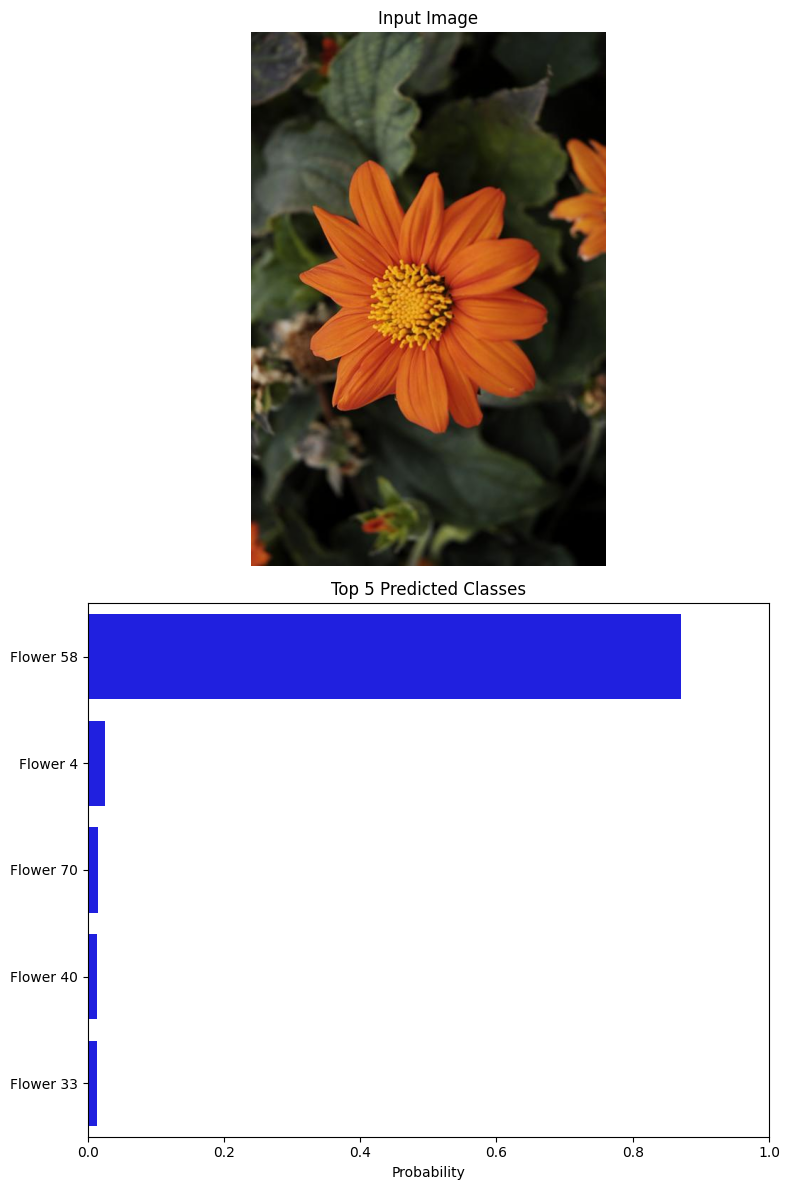

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

class_names = {str(i): f"Flower {i}" for i in range(102)} 

def plot_predictions(image_path, model, top_k=5):
    probs, classes = predict(image_path, model, top_k)
    class_labels = [class_names[cls] for cls in classes]
    
    # p;ot the Image
    image = Image.open(image_path)
    plt.figure(figsize=(8, 12))

    ax1 = plt.subplot(2, 1, 1)
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title("Input Image")

    # Plot Bar Chart with probabilities
    ax2 = plt.subplot(2, 1, 2)
    sns.barplot(x=probs, y=class_labels, color='blue')
    ax2.set_title("Top 5 Predicted Classes")
    ax2.set_xlabel("Probability")
    ax2.set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

image_path = './test_images/orange_dahlia.jpg'
plot_predictions(image_path, loaded_model, top_k=5)
